In [2]:
!pip install openai langchain langchain-openai langchain-community langgraph chromadb

In [3]:
from google.colab import userdata
from dotenv import load_dotenv
load_dotenv()

# Get the API key from environment variables
openai_api_key = userdata.get("OPENAI_API_KEY")
#openai_api_key = ""

if not openai_api_key:
    raise ValueError("OPENAI_API_KEY not found in environment variables. Please set it in your .env file or as a secret.")


In [4]:
import json
import random
from typing import TypedDict, Dict, List

# LLM
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

# Vector DB
from langchain_community.vectorstores import Chroma
from langchain_core.documents import Document

# Graph
from langgraph.graph import StateGraph, END

In [5]:
# -------------------------------------------------------
# LLM SETUP
# -------------------------------------------------------

llm = ChatOpenAI(model="gpt-4o",api_key=openai_api_key,temperature=0)
embeddings = OpenAIEmbeddings(api_key=openai_api_key,model="text-embedding-3-large")

In [6]:

# -------------------------------------------------------
# VECTOR MEMORY (PAST STRATEGIES)
# -------------------------------------------------------

past_strategies = [
    Document(page_content="When inventory is high and demand is low, discount 10-15%."),
    Document(page_content="If competitor price is lower by 20%, match within 5% margin."),
    Document(page_content="Low inventory and high demand allows premium pricing."),
    Document(page_content="Flash sales increase conversion but reduce margin."),
]

vector_store = Chroma.from_documents(
    documents=past_strategies,
    embedding=embeddings,
    collection_name="pricing_memory"
)

retriever = vector_store.as_retriever(search_kwargs={"k": 2})



In [7]:

# -------------------------------------------------------
# TOOLS (SIMULATED REAL DATA SOURCES)
# -------------------------------------------------------

def inventory_tool(product_id: str):
    return {
        "inventory_level": random.randint(10, 500)
    }

def competitor_price_tool(product_id: str):
    return {
        "competitor_price": round(random.uniform(50, 150), 2)
    }

def demand_forecast_tool(product_id: str):
    return {
        "demand_index": random.choice(["LOW", "MEDIUM", "HIGH"])
    }


TOOLS = {
    "inventory_tool": inventory_tool,
    "competitor_price_tool": competitor_price_tool,
    "demand_forecast_tool": demand_forecast_tool
}


In [8]:


# -------------------------------------------------------
# STATE
# -------------------------------------------------------

class PricingState(TypedDict):
    product_id: str
    base_price: float

    tool_plan: List[str]
    tool_results: Dict[str, Dict]

    memory_context: List[str]

    new_price: float
    promotion_strategy: str
    explanation: str


In [9]:


# -------------------------------------------------------
# ORCHESTRATOR AGENT (PLANNER)
# -------------------------------------------------------

def orchestrator_agent(state: PricingState):

    prompt = f"""
    You are an e-commerce pricing orchestrator.

    Product: {state["product_id"]}
    Base price: {state["base_price"]}

    Available tools:
    - inventory_tool
    - competitor_price_tool
    - demand_forecast_tool

    Decide which tools should be used to determine pricing.

    Respond ONLY in JSON:
    {{
        "tools": ["tool_name1", "tool_name2"]
    }}
    """

    response = llm.invoke(prompt).content.strip()

    try:
        parsed = json.loads(response)
        state["tool_plan"] = parsed["tools"]
    except:
        state["tool_plan"] = ["inventory_tool", "competitor_price_tool", "demand_forecast_tool"]

    return state


In [10]:
# -------------------------------------------------------
# TOOL EXECUTION AGENT
# -------------------------------------------------------

def tool_execution_agent(state: PricingState):

    results = {}

    for tool_name in state["tool_plan"]:
        tool_func = TOOLS.get(tool_name)
        if tool_func:
            results[tool_name] = tool_func(state["product_id"])

    state["tool_results"] = results
    return state


# -------------------------------------------------------
# MEMORY RETRIEVAL AGENT
# -------------------------------------------------------

def memory_agent(state: PricingState):

    query = f"Pricing strategy for {state['tool_results']}"
    docs = retriever.invoke(query)

    state["memory_context"] = [d.page_content for d in docs]
    return state


# -------------------------------------------------------
# PRICING STRATEGIST AGENT
# -------------------------------------------------------

def pricing_agent(state: PricingState):

    prompt = f"""
    You are a pricing strategist.

    Base price: {state["base_price"]}
    Tool results: {state["tool_results"]}

    Past strategy knowledge:
    {state["memory_context"]}

    Decide new price (numeric only).
    """

    response = llm.invoke(prompt).content.strip()

    try:
        state["new_price"] = float(response)
    except:
        state["new_price"] = state["base_price"]

    return state


# -------------------------------------------------------
# PROMOTION AGENT
# -------------------------------------------------------

def promotion_agent(state: PricingState):

    prompt = f"""
    You are a promotion strategist.

    New price: {state["new_price"]}
    Demand and inventory context: {state["tool_results"]}

    Suggest promotion strategy in one sentence.
    """

    state["promotion_strategy"] = llm.invoke(prompt).content
    return state


# -------------------------------------------------------
# EXPLANATION AGENT
# -------------------------------------------------------

def explanation_agent(state: PricingState):

    prompt = f"""
    Explain final pricing decision clearly.

    Base price: {state["base_price"]}
    New price: {state["new_price"]}
    Tool results: {state["tool_results"]}
    Promotion: {state["promotion_strategy"]}
    """

    state["explanation"] = llm.invoke(prompt).content
    return state

In [11]:
# -------------------------------------------------------
# GRAPH BUILDING
# -------------------------------------------------------

graph = StateGraph(PricingState)

graph.add_node("orchestrator", orchestrator_agent)
graph.add_node("tool_execution", tool_execution_agent)
graph.add_node("memory", memory_agent)
graph.add_node("pricing", pricing_agent)
graph.add_node("promotion", promotion_agent)
graph.add_node("explanation", explanation_agent)

graph.set_entry_point("orchestrator")

graph.add_edge("orchestrator", "tool_execution")
graph.add_edge("tool_execution", "memory")
graph.add_edge("memory", "pricing")
graph.add_edge("pricing", "promotion")
graph.add_edge("promotion", "explanation")
graph.add_edge("explanation", END)

app = graph.compile()



In [12]:
# -------------------------------------------------------
# RUN SYSTEM
# -------------------------------------------------------

if __name__ == "__main__":

    result = app.invoke({
        "product_id": "SKU-123",
        "base_price": 100.0,
        "tool_plan": [],
        "tool_results": {},
        "memory_context": [],
        "new_price": 0.0,
        "promotion_strategy": "",
        "explanation": ""
    })

    print("\n====== FINAL PRICING DECISION ======")
    print("New Price:", result["new_price"])
    print("Promotion:", result["promotion_strategy"])
    print("\nExplanation:\n", result["explanation"])



====== FINAL PRICING DECISION ======
New Price: 95.0
Promotion: Implement a limited-time discount or bundle offer to boost demand and reduce inventory, while highlighting the competitive advantage of the new price compared to the competitor's higher price.

Explanation:
 The final pricing decision involves setting the new price at $95.00, down from the base price of $100.00. This decision is influenced by several factors derived from the tools and market conditions:

1. **Inventory Levels**: The inventory tool indicates that the inventory level is at 246 units. This suggests that there is a significant amount of stock that needs to be moved. Reducing the price can help increase sales velocity and reduce inventory levels.

2. **Competitor Pricing**: The competitor price tool shows that a competitor is selling a similar product at $137.57. By setting the new price at $95.00, you are offering a substantial discount compared to the competitor, which can attract price-sensitive customers a

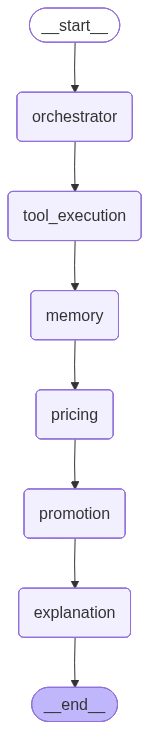

In [13]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))